# Тестирование моделей для предсказания activity

## Импорты, константы, дефолтные настройки

### Установка пакетов

In [1]:
# !uv pip install scikit-learn==1.5.2

Using Python 3.10.12 environment at: /nfs/home/okryuchkov/nnzms/.venv
Resolved 5 packages in 529ms                                         
Prepared 5 packages in 3.84s                                             
Installed 5 packages in 522ms                               
 + joblib==1.4.2
 + numpy==2.2.5
 + scikit-learn==1.5.2
 + scipy==1.15.2
 + threadpoolctl==3.6.0


In [4]:
!uv pip install pandas

Using Python 3.10.12 environment at: /nfs/home/okryuchkov/nnzms/.venv
Resolved 6 packages in 385ms                                         
Prepared 3 packages in 2.45s                                             
Installed 3 packages in 535ms                               
 + pandas==2.2.3
 + pytz==2025.2
 + tzdata==2025.2


In [7]:
!uv pip install optuna

Using Python 3.10.12 environment at: /nfs/home/okryuchkov/nnzms/.venv
Resolved 12 packages in 541ms                                        
Prepared 7 packages in 1.05s                                             
Installed 7 packages in 109ms                               
 + alembic==1.15.2
 + colorlog==6.9.0
 + greenlet==3.2.1
 + mako==1.3.10
 + optuna==4.3.0
 + sqlalchemy==2.0.40
 + tqdm==4.67.1


In [10]:
!uv pip install ipywidgets

Using Python 3.10.12 environment at: /nfs/home/okryuchkov/nnzms/.venv
Resolved 21 packages in 378ms                                        
Prepared 3 packages in 254ms                                             
Installed 3 packages in 58ms.0.14                           
 + ipywidgets==8.1.6
 + jupyterlab-widgets==3.0.14
 + widgetsnbextension==4.0.14


In [13]:
!uv pip install catboost

Using Python 3.10.12 environment at: /nfs/home/okryuchkov/nnzms/.venv
Resolved 19 packages in 559ms                                        
Prepared 11 packages in 18.95s                                           
Installed 11 packages in 5.13s                              
 + catboost==1.2.8
 + contourpy==1.3.2
 + cycler==0.12.1
 + fonttools==4.57.0
 + graphviz==0.20.3
 + kiwisolver==1.4.8
 + matplotlib==3.10.1
 + narwhals==1.37.1
 + pillow==11.2.1
 + plotly==6.0.1
 + pyparsing==3.2.3


In [21]:
!uv pip install seaborn

Using Python 3.10.12 environment at: /nfs/home/okryuchkov/nnzms/.venv
Resolved 15 packages in 408ms                                        
Prepared 1 package in 164ms                                              
Installed 1 package in 30ms                                 
 + seaborn==0.13.2


### импорты

In [1]:
# Импорт модуля для сохранения пайплайна
import os
import joblib

In [2]:
# Импортируем классы для создания пайплайна
from pipeline_classes import *

In [3]:
# Убираем необязательные предупреждения
import warnings
warnings.filterwarnings('ignore')

# Настраиваем полное отображение всех строк таблицы
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Скрываем журнал с триалами
optuna.logging.set_verbosity(optuna.logging.WARNING)

## Загрузка данных

In [4]:
import os
import sys

sys.path += [os.path.abspath("..")]
import pandas as pd
import functions.unifyer as uf

In [5]:
f1 = pd.read_csv("../data/existing_datasets/final_df.csv")
f2 = pd.read_csv("../final_p2.2.csv")
f1 = f1[f2.columns]
print(f1.shape, f2.shape)

(1130, 43) (2200, 43)


In [6]:
# s2 = pd.read_csv("../start_p2.csv")
# condition = (s2["formula"].apply(uf.is_valid_formula) * \
#              (f2[["X", "IR", "pot2"]].isna().sum(axis=1) != 3) * \
#               s2[["formula", "activity"]].notna().sum(axis=1) == 2 * \
#              )
# f2 = f2[condition]
f2 = f2[((f2["activity"] != "multi-activity") * (~f2["activity"].isna()))]
print(f2.shape)

(2174, 43)


In [7]:
df = pd.concat([f1.fillna(0), f2.fillna(0)], ignore_index=True)
df = df.drop(columns=["id"])
df.shape

(3304, 42)

In [8]:
df.columns

Index(['Km', 'Vmax', 'activity', 'X', 'IR', 'pot2', 'ph', 'temp', 'dstr',
       'lgCmin', 'lgCmax', 'Cmin', 'Cmax', 'lgCconst', 'Cconst', 'lgCcat',
       'Ccat', 'lgvolume', 'MolWt', 'PEOE_VSA7', 'PEOE_VSA9', 'VSA_EState8',
       'Kappa2', 'BalabanJ', 'MinAbsEStateIndex', 'MinEStateIndex',
       'EState_VSA6', 'VSA_EState4', 'PEOE_VSA8', 'MinPartialCharge',
       'EState_VSA4', 'SMR_VSA7', 'Complexity1', 'TPSA1', 'TPSA2', 'TPSA',
       'XLogP', 'MaxEStateIndex.1', 'MaxEStateIndex.2', 'MinPartialCharge.1',
       'MaxPartialCharge.1', 'BCUT2D_CHGLO'],
      dtype='object')

In [10]:
# Загружаем список входных признаков, коррелирующих с целевым
# with open("corr_with_activity2.2.txt", "r") as file_activity:
#     corr_with_activity = file_activity.read().splitlines()

corr_with_activity = [
    'X', 'IR', 'pot2', 'dstr', 'lgvolume',
    'MolWt', 'PEOE_VSA7', 'PEOE_VSA9', 'VSA_EState8',
    'Kappa2', 'BalabanJ', 'MinAbsEStateIndex', 'MinEStateIndex',
    'EState_VSA6', 'VSA_EState4', 'PEOE_VSA8', 'MinPartialCharge',
    'EState_VSA4', 'SMR_VSA7', 'TPSA',
    'XLogP', 'BCUT2D_CHGLO']

print(f'Количество коррелирующих признаков: {len(corr_with_activity)}')
print(corr_with_activity)

Количество коррелирующих признаков: 22
['X', 'IR', 'pot2', 'dstr', 'lgvolume', 'MolWt', 'PEOE_VSA7', 'PEOE_VSA9', 'VSA_EState8', 'Kappa2', 'BalabanJ', 'MinAbsEStateIndex', 'MinEStateIndex', 'EState_VSA6', 'VSA_EState4', 'PEOE_VSA8', 'MinPartialCharge', 'EState_VSA4', 'SMR_VSA7', 'TPSA', 'XLogP', 'BCUT2D_CHGLO']


## Предобработка данных

In [11]:
print(f'Размер первоначального датафрейма: {df.shape}')

Размер первоначального датафрейма: (3304, 42)


In [12]:
df['activity'] = df['activity'].replace({1: "peroxidase", 2: "oxidase", 3: "catalase", 4: "laccase"})
category2num = {cat: i+1 for i, cat in enumerate(df['activity'].value_counts().index.tolist())}
print(category2num)
df['activity'] = df['activity'].replace(category2num)

{'peroxidase': 1, 'oxidase': 2, 'catalase': 3, 'superoxide dismutase': 4, 'phosphatase': 5, 'esterase': 6, 'reductase': 7, 'laccase': 8, 'glycosidase': 9, 'uricase': 10, 'dnase': 11, 'rnase': 12, 'hydrolase': 13, 'phosphotriesterase': 14, 'epoxydase': 15}


In [13]:
# Удаляем дубликаты
df = df.drop_duplicates()
print(f'Размер датафрейма после удаления дубликатов: {df.shape}')

Размер датафрейма после удаления дубликатов: (3151, 42)


In [14]:
df['activity'].value_counts()

activity
1     2628
2      313
3      132
4       40
5       11
6        9
8        4
9        4
7        3
10       2
11       1
12       1
13       1
14       1
15       1
Name: count, dtype: int64

In [15]:
# Сохранение примеров только с такими активностями, которые представлены в датасете больше 10 раз
interesting_activities = [1, 2, 3, 4, 5, 6]
df = df[df['activity'].astype(int).isin(interesting_activities)]
# df['activity'] = df['activity'].replace({key: i+1 for i, key in enumerate(interesting_activities)})
print(f'Размер датафрейма после выбора элементов с определёнными activity: {df.shape}')

Размер датафрейма после выбора элементов с определёнными activity: (3133, 42)


In [16]:
# Преобразование типов и замена "no" на NaN
df['Vmax'] = pd.to_numeric(df['Vmax'].replace("no", np.nan), errors='coerce')
df['Km'] = pd.to_numeric(df['Km'].replace("no", np.nan), errors='coerce')

invalid_values = list(df['ph'][~df['ph'].apply(lambda x: pd.to_numeric(x, errors='coerce')).notna()])
df['ph'] = pd.to_numeric(df['ph'].where(lambda ph: ~ph.isin(invalid_values)), errors='coerce')

# Проверяем что сделали корректно
print(df[['Vmax', 'Km', 'ph']].dtypes)

Vmax    float64
Km      float64
ph      float64
dtype: object


In [17]:
# Оставляем в датафрейме только те признаки, которые коррелируют с целевым
df = df[corr_with_activity + ['activity']]
print(f'Размеры датафрейма: {df.shape}')
print(f'Количество дубликатов после удаления признаков: {df.duplicated().sum()}')
df = df.drop_duplicates()

Размеры датафрейма: (3133, 23)
Количество дубликатов после удаления признаков: 1388


In [18]:
df.activity.value_counts()

activity
1    1375
2     220
3     103
4      33
5       7
6       7
Name: count, dtype: int64

## Тестирование моделей

### Разбивка датафрейма на тренировочную и тестовыю выбрки

In [19]:
# Разделяем на целевой признак и на входные
X = df.drop('activity', axis=1)
y = pd.DataFrame(df['activity'])

# Разделяем данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

# Стераем названия колонок
X.columns.name = ''
X_train.columns.name = ''
X_test.columns.name = ''

# Преобразуем целевой признак в формат даафрейма
y = pd.DataFrame(y)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

# Стераем старые индексы
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Вывод размеров датафреймов
print(f"Размер X_train: {X_train.shape}")
print(f"Размер y_train: {y_train.shape}")
print(f"Размер X_test: {X_test.shape}")
print(f"Размер y_test: {y_test.shape}")

Размер X_train: (1308, 22)
Размер y_train: (1308, 1)
Размер X_test: (437, 22)
Размер y_test: (437, 1)


## Сохранение тестовой выборки для интерпретации модели

In [20]:
sub_folder = "full_df2.2.no_experiment"
# Создаем папку
os.makedirs(f'test_train_data/{sub_folder}', exist_ok=True)

# Сохраняем данные
X_train.to_csv(f'test_train_data/{sub_folder}/X_train.csv', index=False)
y_train.to_csv(f'test_train_data/{sub_folder}/y_train.csv', index=False)
X_test.to_csv(f'test_train_data/{sub_folder}/X_test.csv', index=False)
y_test.to_csv(f'test_train_data/{sub_folder}/y_test.csv', index=False)

# Проверка, что файлы сохранены
files = [f'test_train_data/{sub_folder}/X_train.csv', f'test_train_data/{sub_folder}/y_train.csv',
         f'test_train_data/{sub_folder}/X_test.csv', f'test_train_data/{sub_folder}/y_test.csv']
if all(os.path.exists(file) for file in files):
    print("Данные успешно сохранены.")
else:
    print("Ошибка: Не все данные сохранились!")

Данные успешно сохранены.


### Подбор параметров, сравнение моделей

In [21]:
# Создаём экземпляр класса, задаём необходимые данные и настройки, запускаем подбор
study = Study(X_train, y_train, X_test, y_test, cv_num=5)
models_for_test_list = ['LogisticRegression', 'KNNClassifier', 'SVC', 'DecisionTreeClassifier', 'RandomForestClassifier', 'CatBoostClassifier', 'MLPClassifier']
study.set_models_list(models_for_test_list)
study.set_model_score('roc_auc')
study.set_trials_num(20)
study.set_show_trials_num(1)
study.run()

  0%|          | 0/20 [00:00<?, ?it/s]

LogisticRegression,roc_auc,duration,num_encoding,C,imputer_neighbors,n_quantiles,output_distribution,solver_and_penalty,weights
1,0.690916,00:00:02.040925,PowerTransformer standardize=True,40.536315,34,NaN,NaN,saga + l1,uniform


  0%|          | 0/20 [00:00<?, ?it/s]

KNNClassifier,roc_auc,duration,num_encoding,algorithm,imputer_neighbors,n_neighbors,n_quantiles,output_distribution,p,weights
1,0.686054,00:00:00.241239,StandardScaler,ball_tree,12,67,NaN,NaN,1,uniform


  0%|          | 0/20 [00:00<?, ?it/s]

SVC,roc_auc,duration,num_encoding,C,imputer_neighbors,kernel,n_quantiles,output_distribution,weights
1,0.681664,00:00:03.874353,QuantileTransformer,7.731854,30,rbf,96.0,normal,uniform


  0%|          | 0/20 [00:00<?, ?it/s]

DecisionTreeClassifier,roc_auc,duration,num_encoding,criterion,imputer_neighbors,max_depth,max_features,min_samples_leaf,min_samples_split,n_quantiles,output_distribution,splitter,weights
1,0.73062,00:00:00.223865,MaxAbsScaler,entropy,16,9,None,17,14,NaN,NaN,best,distance


  0%|          | 0/20 [00:00<?, ?it/s]

RandomForestClassifier,roc_auc,duration,num_encoding,bootstrap,criterion,imputer_neighbors,max_depth,max_features,max_leaf_nodes,min_samples_leaf,min_samples_split,n_estimators,n_quantiles,output_distribution,weights
1,0.776976,00:00:07.127767,RobustScaler,True,entropy,10,9,7,13,6,10,336,NaN,NaN,uniform


  0%|          | 0/20 [00:00<?, ?it/s]

CatBoostClassifier,roc_auc,duration,num_encoding,auto_class_weights,bagging_temperature,border_count,depth,grow_policy,imputer_neighbors,l2_leaf_reg,leaf_estimation_iterations,leaf_estimation_method,learning_rate,n_quantiles,output_distribution,random_strength,weights,iterations
1,0.819143,00:00:30.460868,PowerTransformer standardize=False,None,0.733678,203,4,Lossguide,21,5.167442,4,Gradient,0.041732,NaN,NaN,0.936482,distance,658


  0%|          | 0/20 [00:00<?, ?it/s]

MLPClassifier,roc_auc,duration,num_encoding,activation,alpha,hidden_layer_sizes,imputer_neighbors,learning_rate,n_quantiles,output_distribution,solver,weights
1,0.735612,00:00:03.731798,PowerTransformer standardize=True,relu,0.00034,"(50,)",11,constant,NaN,NaN,adam,uniform


models_best_results,model,roc_auc_cv,roc_auc_test
1,CatBoostClassifier,0.819143,0.808511
2,RandomForestClassifier,0.776976,0.797442
3,MLPClassifier,0.735612,0.768461
4,DecisionTreeClassifier,0.730620,0.716672
5,LogisticRegression,0.690916,0.746509
6,KNNClassifier,0.686054,0.730282
7,SVC,0.681664,0.716265


## Стекинг моделей

In [22]:
# Сохраняем наиболее интересные модели в переменные
svc_pipe = study.best_piplines_dict['MLPClassifier']
rf_pipe = study.best_piplines_dict['RandomForestClassifier']
cb_pipe = study.best_piplines_dict['CatBoostClassifier']

In [23]:
# Создание ансамбля
ensemble_model = StackingClassifier(
    estimators=[
        ('svc', svc_pipe),
        ('rf', rf_pipe),
        ('cb', cb_pipe)
    ],
    final_estimator=LogisticRegression(),
    cv=5
)

# Обучение ансамбля
ensemble_model.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('svc',
                                Pipeline(steps=[('feature_engineering',
                                                 FunctionTransformer(func=<bound method Objective.do_feature_engineering of <pipeline_classes.ObjectiveClassifier object at 0x7062d89f15e0>>,
                                                                     kw_args={})),
                                                ('imputer',
                                                 KNNImputer(n_neighbors=11)),
                                                ('num', PowerTransformer()),
                                                ('model',
                                                 MLPClassifier(alpha=0.00034047667156493814,
                                                               hidd...
                                                 FunctionTransformer(func=<bound method Objective.do_feature_engineering of <pipeline_classes.ObjectiveClassifier object at 0x7062d89f15e0>>,
                                                                     kw_args={})),
                                                ('imputer',
                                                 KNNImputer(n_neighbors=21,
                                                            weights='distance')),
                                                ('num',
                                                 PowerTransformer(standardize=False)),
                                                ('model',
                                                 <catboost.core.CatBoostClassifier object at 0x7062d8bf0c80>)]))],
                   final_estimator=LogisticRegression())

In [24]:
# Получаем предсказания лучшей модели
proba = ensemble_model.predict_proba(X_test)
pred = ensemble_model.predict(X_test)

# Считаем метрики
auroc = roc_auc_score(y_test, proba, multi_class='ovr', average='macro')
accuracy = accuracy_score(y_test, pred)

# Выводим метрики на экран
print(f"AUROC для стекинговой модели: {auroc}")
print(f"Accuracy для стекинговой модели: {accuracy}")

AUROC для стекинговой модели: 0.7824635847331316
Accuracy для стекинговой модели: 0.8032036613272311


In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Confusion Matrix. Test dataset\nAUROC: 0.782; Accuracy: 0.803')

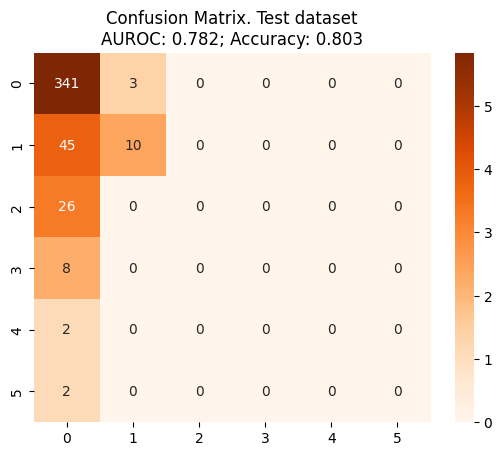

In [26]:
cm_test = confusion_matrix(y_test, pred)
sns.heatmap(
    np.log1p(cm_test),
    annot=cm_test,
    fmt='d',
    cmap='Oranges'
)
plt.title(("Confusion Matrix. Test dataset\n"
           f"AUROC: {auroc:.3f}; Accuracy: {accuracy:.3f}"))

In [27]:
# Получаем предсказания лучшей модели
probatr = ensemble_model.predict_proba(X_train)
predtr = ensemble_model.predict(X_train)

# Считаем метрики
auroctr = roc_auc_score(y_train, probatr, multi_class='ovr', average='macro')
accuracytr = accuracy_score(y_train, predtr)

# Выводим метрики на экран
print(f"AUROC для стекинговой модели: {auroctr}")
print(f"Accuracy для стекинговой модели: {accuracytr}")

AUROC для стекинговой модели: 0.9104085834886463
Accuracy для стекинговой модели: 0.8478593272171254


Text(0.5, 1.0, 'Confusion Matrix. Train dataset\nAUROC: 0.910; Accuracy: 0.848')

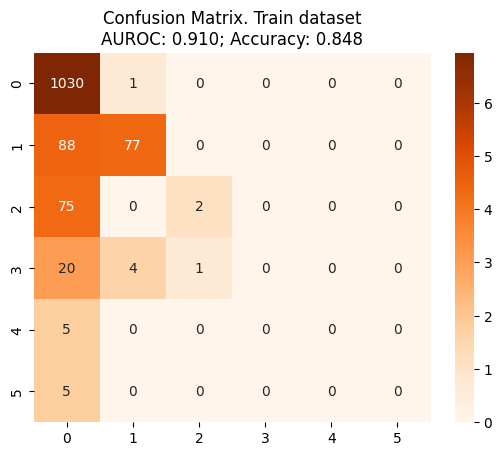

In [28]:
cm_train = confusion_matrix(y_train, predtr)
sns.heatmap(
    np.log1p(cm_train),
    annot=cm_train,
    fmt='d',
    cmap='Oranges'
)
plt.title(("Confusion Matrix. Train dataset\n"
           f"AUROC: {auroctr:.3f}; Accuracy: {accuracytr:.3f}"))

## Сохранение лучших моделей в файлы

In [25]:
# Создаем папку models, если она не существует
os.makedirs(f'saved_models/{sub_folder}', exist_ok=True)

# Сохраняем модели в папку models
joblib.dump(svc_pipe, f'saved_models/{sub_folder}/svc.pkl')
joblib.dump(rf_pipe, f'saved_models/{sub_folder}/random_forest.pkl')
joblib.dump(cb_pipe, f'saved_models/{sub_folder}/catboost.pkl')
joblib.dump(ensemble_model, f'saved_models/{sub_folder}/ensemble_model.pkl')

# Проверка, что файлы существуют
files = [f'saved_models/{sub_folder}/svc.pkl',
         f'saved_models/{sub_folder}/random_forest.pkl',
         f'saved_models/{sub_folder}/catboost.pkl',
         f'saved_models/{sub_folder}/ensemble_model.pkl']

for file in files:
    if os.path.exists(file):
        print(f"Файл {file} успешно создан.")
    else:
        print(f"Ошибка: файл {file} не был создан.")

Файл saved_models/full_df2.2/svc.pkl успешно создан.
Файл saved_models/full_df2.2/random_forest.pkl успешно создан.
Файл saved_models/full_df2.2/catboost.pkl успешно создан.
Файл saved_models/full_df2.2/ensemble_model.pkl успешно создан.
